## Midi Classifier

In [1]:
import numpy as np

from htm.bindings.sdr import SDR
from htm.bindings.encoders import ScalarEncoder, ScalarEncoderParameters
from htm.algorithms import SpatialPooler as SP
from htm.algorithms import TemporalMemory as TM
from htm.bindings.algorithms import Classifier

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline

In [2]:
scalarEncoderParams = ScalarEncoderParameters()
scalarEncoderParams.minimum = 59
scalarEncoderParams.maximum = 72
scalarEncoderParams.activeBits = 3
scalarEncoderParams.size = 24
scalarEncoderParams.clipInput  = True

enc = ScalarEncoder(scalarEncoderParams)

print ("60: ", enc.encode(60))
print ("62: ", enc.encode(62))
print ("64: ", enc.encode(64))
print ("65: ", enc.encode(65))
print ("67: ", enc.encode(67))
print ("69: ", enc.encode(69))
print ("71: ", enc.encode(71))

60:  SDR( 24 ) 2, 3, 4
62:  SDR( 24 ) 5, 6, 7
64:  SDR( 24 ) 8, 9, 10
65:  SDR( 24 ) 10, 11, 12
67:  SDR( 24 ) 13, 14, 15
69:  SDR( 24 ) 16, 17, 18
71:  SDR( 24 ) 19, 20, 21


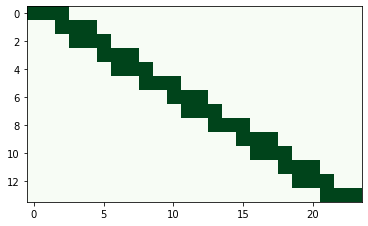

In [3]:
n_samples = int(enc.parameters.maximum - enc.parameters.minimum + 1)

sdrs = []
for i in np.linspace(enc.parameters.minimum, enc.parameters.maximum, n_samples):
  sdrs.append( enc.encode( i ).dense )

plt.imshow(np.array(sdrs), cmap = "Greens")
plt.show()

In [4]:
inputSDR  = SDR( dimensions = (24, ) )
activeSDR = SDR( dimensions = (576,) )
sp = SP(inputDimensions  = inputSDR.dimensions,
        columnDimensions = activeSDR.dimensions,
        localAreaDensity = 0.02,
        globalInhibition = True,
        seed             = 1,
        synPermActiveInc   = 0.01,
        synPermInactiveDec = 0.008)

print(sp)

Spatial Pooler Connections:
    Inputs (24) ~> Outputs (576) via Segments (576)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 12 / 12 / 12
    Connected Synapses on Segment Min/Mean/Max 1 / 5.96181 / 11
    Synapses Dead (0%) Saturated (0%)
    Synapses pruned (0%) Segments pruned (0%)



In [5]:
tm = TM(
    columnDimensions = (576,),
    cellsPerColumn=8,
    initialPermanence=0.5,
    connectedPermanence=0.5,
    minThreshold=8,
    maxNewSynapseCount=20,
    permanenceIncrement=0.1,
    permanenceDecrement=0.0,
    activationThreshold=8,
)
print(tm)

Temporal Memory Connections:
    Inputs (0) ~> Outputs (4608) via Segments (0)
    Segments on Cell Min/Mean/Max 0 / 0 / 0
    Potential Synapses on Segment Min/Mean/Max 4294967295 / nan / 0
    Connected Synapses on Segment Min/Mean/Max 65535 / nan / 0
    Synapses Dead (nan%) Saturated (nan%)
    Synapses pruned (nan%) Segments pruned (nan%)



In [6]:
minimum = 59
resolution = 1
clsr = Classifier()

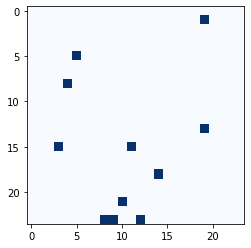

input SDR:  SDR( 24 ) 4, 5, 6
Active SDR:  SDR( 576 ) 150, 194, 235, 285, 330, 543, 548, 550, 551, 569, 571
Classifier learn:  61.5

input SDR:  SDR( 24 ) 5, 6, 7
Active SDR:  SDR( 576 ) 52, 235, 294, 346, 426, 533, 543, 544, 548, 550, 571
Classifier learn:  62.1415926535



In [7]:
for i in range(60,72):
    inputSDR = enc.encode(i)
    print("input SDR: ",inputSDR)
    sp.compute(inputSDR, True, activeSDR)
    print("Active SDR: ",activeSDR)
    clsr.learn( activeSDR, int((i - minimum) / resolution)  )
    print("Classifier learn: ",i)
    print("")

    clear_output(wait = True)
    plt.cla
    sampleSDR=activeSDR.dense.reshape(24,24)
    plt.imshow(sampleSDR, cmap = "Blues")
    plt.pause(0.01)

scalar = 61.5
inputSDR = enc.encode(scalar)
print("input SDR: ",inputSDR)
sp.compute(inputSDR, True, activeSDR)
print("Active SDR: ",activeSDR)
clsr.learn( activeSDR, int((scalar - minimum) / resolution)  )
print("Classifier learn: ",scalar)
print("")

scalar = 62.1415926535
inputSDR = enc.encode(scalar)
print("input SDR: ",inputSDR)
sp.compute(inputSDR, True, activeSDR)
print("Active SDR: ",activeSDR)
clsr.learn( activeSDR, int((scalar - minimum) / resolution)  )
print("Classifier learn: ",scalar)
print("")

In [8]:
#pitchNames = ("C","D","E","F","G","A","B")
#midi = [60,62,64,65,67,69,71]
seq = [60,60,67,67,69,69,67,65,65,64,64,62,62,60]

#seq_clsr = Classifier()

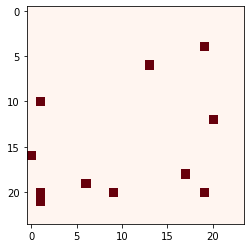

In [9]:
batch=10
for n in range(batch):    
    for i in range(len(seq)):
        inputSDR = enc.encode(seq[i])
        print("input SDR: ",inputSDR)
        sp.compute(inputSDR, True, activeSDR)
        print("Active SDR: ",activeSDR)
        #seq_clsr.learn( activeSDR, i )
       # print("Classifier learn: ",i)
        print("")

        #sampleSDR=activeSDR.dense.reshape(24,24)
        #plt.imshow(sampleSDR, cmap = "Blues")
        #plt.pause(0.01)

        tm.compute( activeSDR, learn=True)
        tm.activateDendrites(True)

        activeColumnsIndices   = [tm.columnForCell(i) for i in tm.getActiveCells().sparse]
        predictedColumnIndices = [tm.columnForCell(i) for i in tm.getPredictiveCells().sparse]

        #print(tm.getActiveCells())
        #print(tm.getPredictiveCells())

        active_sdr = SDR( tm.numberOfColumns() )
        active_sdr.sparse  = np.array(sorted(set(activeColumnsIndices)))
        print("-"*70 )
        print("Active sdr: ", active_sdr)

        predict_sdr = SDR( tm.numberOfColumns() )
        predict_sdr.sparse  = np.array(sorted(set(predictedColumnIndices)))
        print("-"*70 )
        print("Predicted sdr: ",predict_sdr)

        if  len(predict_sdr.sparse) == 0:
            tm_predict = "nan"
        else:
            tm_predict = np.argmax( clsr.infer( predict_sdr) )  * resolution + minimum
        print("-"*70 )
        print("PDF: ",clsr.infer( predict_sdr) )
        print("-"*70 )

        print("predict midi: ",tm_predict)

        print("")

        
        clear_output(wait = True)
        plt.cla
        sampleSDR=predict_sdr.dense.reshape(24,24)
        plt.imshow(sampleSDR, cmap = "Reds")
        plt.pause(0.01)

In [10]:
for i in range(len(seq)):
    print("--- ", i ," ---")
    inputSDR = enc.encode(seq[i])
    print("input SDR: ",inputSDR)
    sp.compute(inputSDR, True, activeSDR)
    print("Active SDR: ",activeSDR)
    print("")

    #sampleSDR=activeSDR.dense.reshape(24,24)
    #plt.imshow(sampleSDR, cmap = "Blues")
    #plt.pause(0.01)

    tm.compute( activeSDR, learn=False)
    tm.activateDendrites(True)
    activeColumnsIndices   = [tm.columnForCell(i) for i in tm.getActiveCells().sparse]
    predictedColumnIndices = [tm.columnForCell(i) for i in tm.getPredictiveCells().sparse]

    #print(tm.getActiveCells())
    #print(tm.getPredictiveCells())

    active_sdr = SDR( tm.numberOfColumns() )
    active_sdr.sparse  = np.array(sorted(set(activeColumnsIndices)))
    print("-"*70 )
    print("Active sdr: ", active_sdr)

    predict_sdr = SDR( tm.numberOfColumns() )
    predict_sdr.sparse  = np.array(sorted(set(predictedColumnIndices)))
    print("-"*70 )
    print("Predicted sdr: ",predict_sdr)

    if  len(predict_sdr.sparse) == 0:
        tm_predict = "nan"
        tm_pitchNames = "nan"      
    else:
        tm_predict = np.argmax( clsr.infer( predict_sdr) )  * resolution + minimum

    print("-"*70 )
    print("PDF: ",clsr.infer( predict_sdr) )
    print("-"*70 )

    print("predict midi: ",tm_predict)

    print("")

    #clear_output(wait = True)
    #plt.cla
    #sampleSDR=predict_sdr.dense.reshape(24,24)
    #plt.imshow(sampleSDR, cmap = "Reds")
    #plt.pause(0.01)

---  0  ---
input SDR:  SDR( 24 ) 2, 3, 4
Active SDR:  SDR( 576 ) 115, 157, 241, 308, 384, 449, 462, 481, 489, 499, 505

----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 115, 157, 241, 308, 384, 449, 462, 481, 489, 499, 505
----------------------------------------------------------------------
Predicted sdr:  SDR( 576 ) 10, 55, 66, 78, 115, 145, 157, 241, 258, 281, 308, 324, 364, 384, 449, 462, 481, 486, 489, 499, 505, 572
----------------------------------------------------------------------
PDF:  [0.07628844818546511, 0.07713184221899533, 0.07701642716388206, 0.07681132028549055, 0.07681130831255993, 0.07681128909445514, 0.07681127179029813, 0.07688805934120269, 0.07767058754337035, 0.07699180269098958, 0.07692254123520051, 0.07692254123520051, 0.07692254123520051]
----------------------------------------------------------------------
predict midi:  67

---  1  ---
input SDR:  SDR( 24 ) 2, 3, 4
Active SDR:  SDR( 576 ) 115, 157, 241, 308, 

In [11]:
[60,60,67,67,69,69,67,65,65,64,64,62,62,60]

[60, 60, 67, 67, 69, 69, 67, 65, 65, 64, 64, 62, 62, 60]

In [ ]:
[60,67,67,67,69,69,67,65,65,64,64,62,62,60]